<a href="https://colab.research.google.com/github/marcelpinheiro/malum/blob/master/pyspark/pyspark_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Marcel Borges Pinheiro - marcelpinheiro@gmail.com

# Table of contents
[Reading and transforming data with pandas](#pandas)

[Working with Spark using pyspak](#spark)

[Graphs with matplotlib](#matplotlib)

### Downloading dependencies

In [19]:
# !wget https://github.com/marcelpinheiro/malum/raw/master/pyspark/autos.csv
# !wget https://github.com/marcelpinheiro/malum/raw/master/pyspark/car_sites.csv
!pip install pyspark

     |████████████████████████████████| 204.7MB 63kB/s 
     |████████████████████████████████| 204kB 44.6MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.0-py2.py3-none-any.whl size=205044182 sha256=2122ab532e1a8529d3a996e3cf666a47f61c4fb8857b55008bb958804a7a5c39
  Stored in directory: /root/.cache/pip/wheels/57/27/4d/ddacf7143f8d5b76c45c61ee2e43d9f8492fc5a8e78ebd7d37
Successfully built pyspark


### Reading and transforming data with pandas <a class="anchor" id="pandas"> </a>

In [15]:
import pandas as pd


#read csv
autos = pd.read_csv("autos.csv", encoding='cp1252')

#convert to date and remove time
autos["dateCrawled"] = pd.to_datetime(autos["dateCrawled"]) 
autos["dateCrawled"] = autos["dateCrawled"].dt.date

#translate vehicle types and put a type "Not specified" where the type and model was not specified
autos["vehicleType"] = autos["vehicleType"].str.replace("kleinwagen", "small car")
autos["vehicleType"] = autos["vehicleType"].fillna("Not specified")
autos["model"] = autos["model"].fillna("Not specified")
autos["gearbox"] = autos["gearbox"].str.replace("manuell", "manual")
autos["gearbox"] = autos["gearbox"].str.replace("automatik", "automatic")

#format name
autos["name"] = autos["name"].str.replace("_"," ")

#convert price into float
autos["price"] = autos["price"].str.replace("$","").str.replace(",","").astype(float)

autos.head(10)



,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,odometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03-26,Peugeot 807 160 NAVTECH ON BOARD,privat,Angebot,5000.0,control,bus,2004,manual,158,andere,"150,000km",3,lpg,peugeot,nein,2016-03-26 00:00:00,0,79588,2016-04-06 06:45:54
1,2016-04-04,BMW 740i 4 4 Liter HAMANN UMBAU Mega Optik,privat,Angebot,8500.0,control,limousine,1997,automatic,286,7er,"150,000km",6,benzin,bmw,nein,2016-04-04 00:00:00,0,71034,2016-04-06 14:45:08
2,2016-03-26,Volkswagen Golf 1.6 United,privat,Angebot,8990.0,test,limousine,2009,manual,102,golf,"70,000km",7,benzin,volkswagen,nein,2016-03-26 00:00:00,0,35394,2016-04-06 20:15:37
3,2016-03-12,Smart smart fortwo coupe softouch/F1/Klima/Pan...,privat,Angebot,4350.0,control,small car,2007,automatic,71,fortwo,"70,000km",6,benzin,smart,nein,2016-03-12 00:00:00,0,33729,2016-03-15 03:16:28
4,2016-04-01,Ford Focus 1 6 Benzin TÜV neu ist sehr gepfleg...,privat,Angebot,1350.0,test,kombi,2003,manual,0,focus,"150,000km",7,benzin,ford,nein,2016-04-01 00:00:00,0,39218,2016-04-01 14:38:50
5,2016-03-21,Chrysler Grand Voyager 2.8 CRD Aut.Limited Sto...,privat,Angebot,7900.0,test,bus,2006,automatic,150,voyager,"150,000km",4,diesel,chrysler,NaN,2016-03-21 00:00:00,0,22962,2016-04-06 09:45:21
6,2016-03-20,VW Golf III GT Special Electronic Green Metall...,privat,Angebot,300.0,test,limousine,1995,manual,90,golf,"150,000km",8,benzin,volkswagen,NaN,2016-03-20 00:00:00,0,31535,2016-03-23 02:48:59
7,2016-03-16,Golf IV 1.9 TDI 90PS,privat,Angebot,1990.0,control,limousine,1998,manual,90,golf,"150,000km",12,diesel,volkswagen,nein,2016-03-16 00:00:00,0,53474,2016-04-07 03:17:32
8,2016-03-22,Seat Arosa,privat,Angebot,250.0,test,Not specified,2000,manual,0,arosa,"150,000km",10,NaN,seat,nein,2016-03-22 00:00:00,0,7426,2016-03-26 18:18:10
9,2016-03-16,Renault Megane Scenic 1.6e RT Klimaanlage,privat,Angebot,590.0,control,bus,1997,manual,90,megane,"150,000km",7,benzin,renault,nein,2016-03-16 00:00:00,0,15749,2016-04-06 10:46:35


### Working with Spark using pyspak <a class="anchor" id="spark"> </a>

In [20]:
# import findspark
# findspark.init()
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark SQL example - Marcel Pinheiro") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()
    
# spark is an existing SparkSession
rdd = spark.read.csv("autos.csv", header='true') #reading the file again only for example purposes


rdd2 = spark.read.csv("car_sites.csv", header='true') 
# Register the DataFrame as a SQL temporary table
rdd.registerTempTable("auto")
rdd2.registerTempTable("sites")

#Join between two CSV files
sqlDF = spark.sql("SELECT A.name, A.gearbox, A.vehicleType, S.siteaddress FROM auto A LEFT JOIN sites S on A.vehicleType = S.type")
sqlDF.show()






+--------------------+---------+-----------+--------------------+
|                name|  gearbox|vehicleType|         siteaddress|
+--------------------+---------+-----------+--------------------+
|Peugeot_807_160_N...|  manuell|        bus|http://www.busren...|
|BMW_740i_4_4_Lite...|automatik|  limousine|http://www.limous...|
|Volkswagen_Golf_1...|  manuell|  limousine|http://www.limous...|
|Smart_smart_fortw...|automatik| kleinwagen|                null|
|Ford_Focus_1_6_Be...|  manuell|      kombi|http://www.kombir...|
|Chrysler_Grand_Vo...|automatik|        bus|http://www.busren...|
|VW_Golf_III_GT_Sp...|  manuell|  limousine|http://www.limous...|
|Golf_IV_1.9_TDI_90PS|  manuell|  limousine|http://www.limous...|
|          Seat_Arosa|  manuell|       null|                null|
|Renault_Megane_Sc...|  manuell|        bus|http://www.busren...|
|VW_Golf_Tuning_in...|  manuell|       null|                null|
|Mercedes_A140_Mot...|     null|       null|                null|
|Smart_sma

### Graphs with matplotlib <a class="anchor" id="matplotlib"> </a>

                        price
yearOfRegistration           
2010                20324.662
2011                23775.999
2012                21927.592


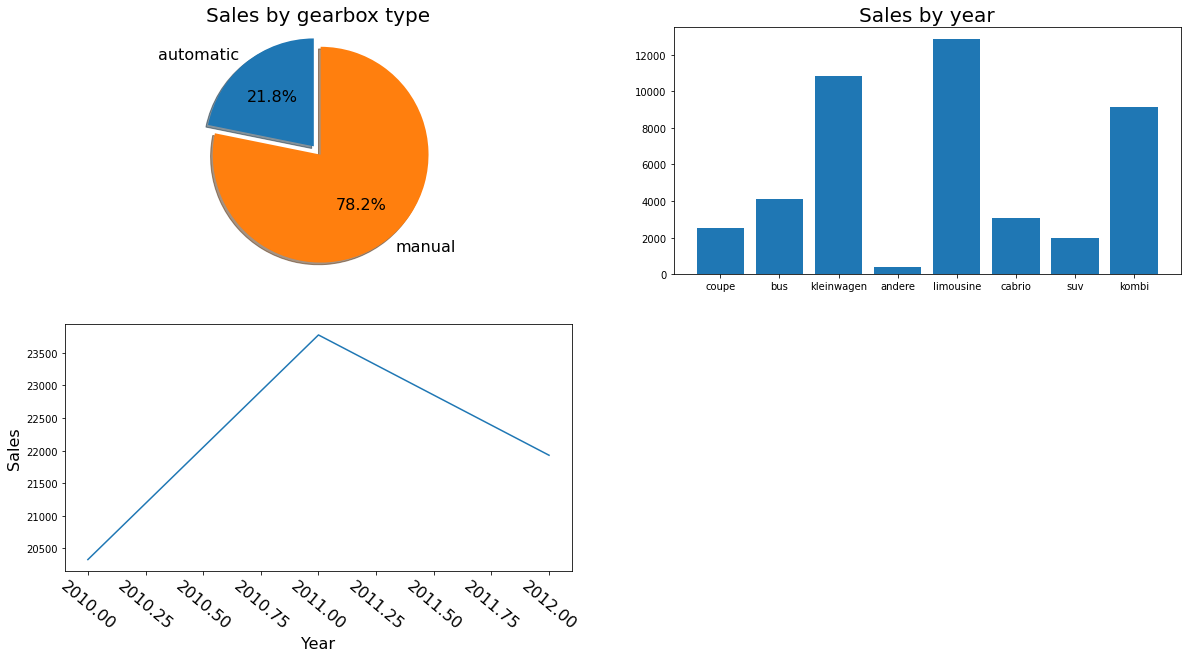

In [21]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import numpy as np
import matplotlib.ticker as ticker

#create dataframe to show in the graphic de amount of sales per year

totalSales = autos.loc[(autos["yearOfRegistration"] >= 2010) & (autos["yearOfRegistration"] <= 2012),["price","yearOfRegistration"]]

# pd.unique(totalSales['yearOfRegistration'])

totalByYear = (totalSales.groupby("yearOfRegistration").sum()/1000)

print(totalByYear)



#Using pyspark to create another graph

sqlrdd = spark.sql("SELECT gearbox, count(gearbox) qty  FROM auto where gearbox IS NOT NULL group by gearbox")
plotPandasGearbox = sqlrdd.toPandas()

plotPandasGearbox['gearbox'] = plotPandasGearbox['gearbox'].str.replace("manuell","manual")
plotPandasGearbox['gearbox'] = plotPandasGearbox['gearbox'].str.replace("automatik","automatic")


sqlrdd2 = spark.sql("SELECT vehicleType, count(vehicleType) qty  FROM auto where vehicleType IS NOT NULL group by vehicleType")
plotPandasCarType = sqlrdd2.toPandas()



fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)

# Pie chart
explode = (0, 0.1)  # "explode" the 2nd slice
ax1.pie(plotPandasGearbox['qty'], explode=explode, labels=plotPandasGearbox['gearbox'], autopct='%1.1f%%', shadow=True, startangle=90,textprops={'fontsize': 16})
ax1.axis('equal')
ax1.set_title('Sales by gearbox type',fontsize=20)


# Bar chart
ax2.bar(plotPandasCarType['vehicleType'],plotPandasCarType['qty'])
plt.xlabel('Year', fontsize=16)
plt.xticks(rotation=320, fontsize=16)
plt.ylabel('Sales', fontsize=16)
ax2.set_title('Sales by year', fontsize=20)

# Line char
ax3.plot(totalByYear)
# ax3.xaxis.set_major_formatter(ticker.FormatStrFormatter(">%d<"))


plt.show()